In [83]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model

In [104]:
df = pd.read_table("amd.us.txt", delimiter=",")
df["Direction"] = np.where(df['Open'] < df['Close'], 1, 0)
print(df.shape)
df.head()

(8737, 8)


,Date,Open,High,Low,Close,Volume,OpenInt,Direction
0,1983-03-21,8.97,9.03,8.81,9.00,528000,0,1
1,1983-03-22,8.72,8.97,8.50,8.50,332400,0,0
2,1983-03-23,8.50,8.81,8.47,8.72,442400,0,1
3,1983-03-24,8.72,8.78,8.66,8.78,412000,0,1
4,1983-03-25,8.91,9.06,8.75,8.88,216400,0,0


<Axes: title={'center': 'AMD stock price over time'}, xlabel='Days since stock creation', ylabel='Share price'>

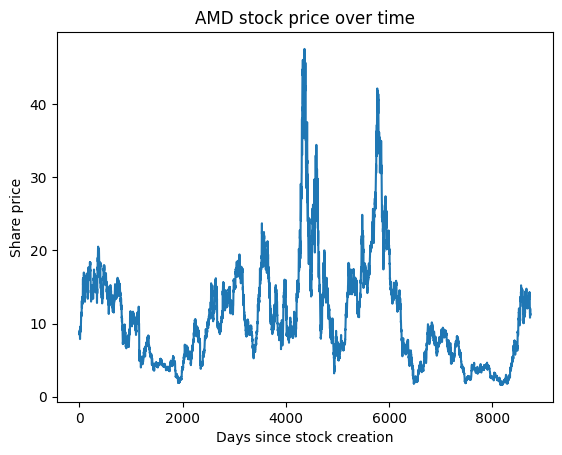

In [105]:
df["Close"].plot(title="AMD stock price over time", xlabel="Days since stock creation", ylabel="Share price")

In [86]:
out = pd.DataFrame(df["Close"])
inp = ["Open", "High", "Low", "Volume"]
scaler = MinMaxScaler()
ft = scaler.fit_transform(df[inp])
ft = pd.DataFrame(columns=inp, data=ft, index=df.index)
ft.head()

,Open,High,Low,Volume
0,0.002321,0.000992,0.024157,0.000000
1,0.007718,0.022441,0.025612,0.505608
2,0.026042,0.036972,0.041124,0.462838
3,0.023910,0.024908,0.032964,0.221531
4,0.018513,0.017347,0.028763,0.138407


In [87]:
# Model Training

for train, test in TimeSeriesSplit(n_splits=10).split(ft):
        X_train, X_test = ft[:len(train)], ft[len(train):(len(train)+len(test))]
        y_train, y_test = out[:len(train)].values.ravel(), out[len(train):(len(train)+len(test))].values.ravel()

comp = pd.DataFrame(df.loc[(df.shape[0]-len(y_test)):df.shape[0], "Open"]).reset_index()

tr = np.array(X_train)
te = np.array(X_test)
X_train = tr.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = te.reshape(X_test.shape[0], 1, X_test.shape[1])

In [88]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, tr.shape[1]), activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
results = model.fit(X_train, y_train, epochs = 50, batch_size = 5, verbose = 1, shuffle=False)

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8627.6924
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7186.0425
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5053.2310
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3016.5117
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1651.9922
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1072.4625
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 968.3743
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 983.1335
Epoch 9/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 906.9406
Epoch 10/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 728.0033
Epoch 11/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 518.1483
Epoch 12/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 333.5698
Epoch 13/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 197.4707
Epoch 14/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 110.6921
Epoch 15/50
338/338 ━━━

In [90]:
# Predictions

pred = model.predict(X_test)
pred = np.squeeze(pred)

correct = 0
total = 0

for i in range(len(y_test)):
  dir = 0
  pdir = 0

  if comp.loc[i,"Open"] < y_test[i]:
    dir = 1
  if comp.loc[i,"Open"] < pred[i]:
    pdir = 1
  if dir == pdir:
    correct += 1
  total += 1

print("Total Correct: " + str(correct) + " out of " + str(total) + " total.")
print("Percentage correct: " + str(correct/total))



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Total Correct: 95 out of 168 total.
Percentage correct: 0.5654761904761905
